# Visualize Route Deviance

As a dispatcher, I may want to verify that my Tracker users are following routes that I have laid out for them. For example, I could have given them a preplanned route using Navigator for ArcGIS - and want to ensure that to go between point A and point B, that they used that route for their safety. This notebook takes a route layer input, a track view, and returns whether or not the user followed the preplanned route. If they have not, it will return a map visualizing the area where the user did not follow the preplanned route. Note that you should have the "view location tracks" privilege to use this notebook.


In [36]:
# import modules
import json
import pendulum
import pandas
import sys

# import arcgis modules
import arcgis
from arcgis.apps.tracker import TrackView
from arcgis.features import FeatureLayerCollection, FeatureLayer, FeatureSet
from arcgis.geometry import Polyline
from arcgis.gis import GIS

## Connect to GIS and extract our route layers

Let's get our saved route layer using the portal item id. For this notebook, we'll be navigating between the Portland Public Library and the Portland International Jetport. Here, we set the username we're both logging in with and we want to query, the default buffer distance (i.e. if a point is within this number, it will be "on" the route), the default basemap we'd like to use, and the default map center.

In [37]:
# Same username used for querying track data
username = ""
buffer_distance = "150" # set as string, not int
default_basemap = 'streets-night-vector'
default_map_center = [43.656247, -70.285417]
default_zoom_level = 12

# Login, return layers
gis = GIS("https://arcgis.com", username, verify_cert=False)
route_item = gis.content.get("3e05069b63264e78854d8d68362554f6")
route_layers = route_item.layers

Enter password: ········


## Visualize route feature collection

Now that we have our layers loaded, let's visualize it using the built in Jupyter notebook map widget. We put some custom visualization on our route layer in the portal just to make it look a little better.


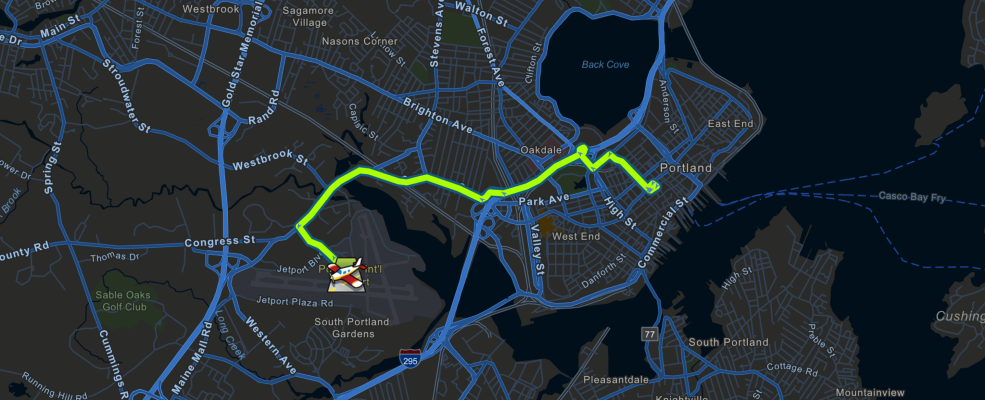

In [44]:
map1 = gis.map(zoomlevel=default_zoom_level)
map1.center = default_map_center
map1.basemap = default_basemap
for layer in route_layers:
    map1.add_layer(layer)
map1

## Visualize track data

Using times in UTC, let's now query all of our tracks between a start and end time and visualize those. 


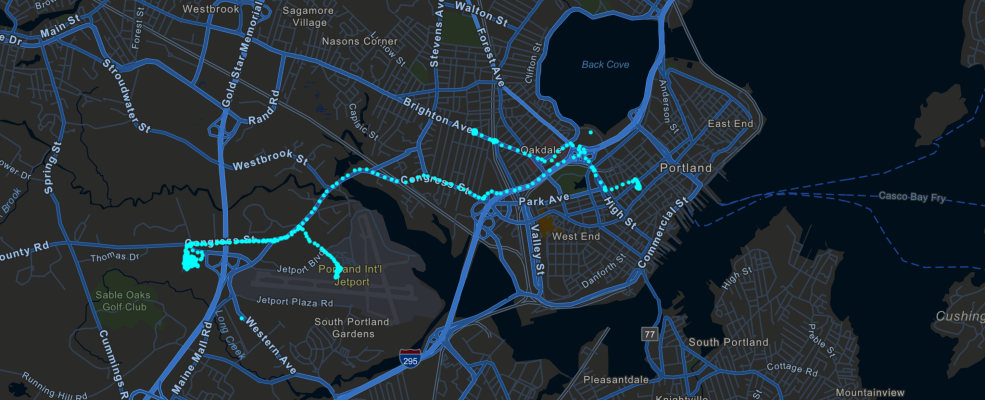

In [46]:
# Filter tracks data by date
start_date_utc = "2020-02-13 01:10:00"
end_date_utc = "2020-02-13 11:10:00"
tracks_layer = TrackView(gis.content.get("39cc476e2dea4d24ba59f26e671fb621")).tracks_layer
where_clause = f"created_user='{username}' AND location_timestamp > timestamp '{start_date_utc}' AND location_timestamp < timestamp '{end_date_utc}'"
tracks_layer.filter = where_clause

# Display map 2 - new map object used to get around Jupyter notebook bug
map2 = gis.map(zoomlevel=default_zoom_level)
map2.center = default_map_center
map2.basemap = default_basemap
map2.add_layer(tracks_layer, {"renderer":{"type":"simple","symbol":{"color":[0,255,255,255],"size":3,"type":"esriSMS","style":"esriSMSCircle"}}})
map2

## Identify potential "end of route" track points

As you can see above, there was clearly some deviance in the western part of the map between the prescribed route and the tracks - when the user went to the airport parking lot. However, filtering solely by time wasn't good enough; we got some tracks from the previous night in the northern part of the map, when we weren't on the preplanned route. Let's instead perform this query by filtering of tracks using geometry intersections; we identify track points that intersect with the start and stop features and then return all points in between those two. 


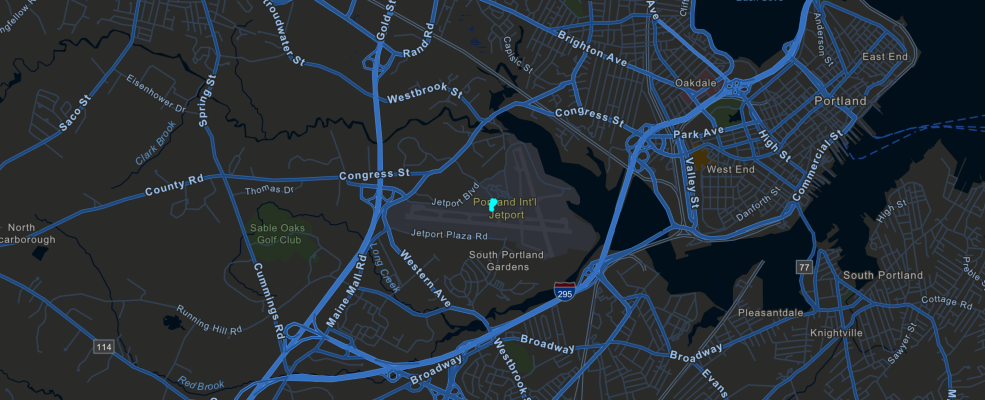

In [47]:
tracks_layer.filter = None
stop_layer = route_layers[3]
points = []

# Convert stop features into list of Point objects
for feature in stop_layer.query().features:
    points.append(arcgis.geometry.Point(json.dumps(feature.geometry)))
buffered_points = arcgis.geometry.buffer(geometries=points,in_sr=102100,distances=buffer_distance,unit=9001,out_sr=4326)
stop_filter = arcgis.geometry.filters.intersects(buffered_points[1], sr=4326)

# Check which track points intersect stop features
end_tracks = tracks_layer.query(where=where_clause, geometry_filter=stop_filter, order_by_fields="location_timestamp ASC")
if len(end_tracks) == 0:
    sys.exit("User did not get near the end of the route in the given time period!")

# Display end of route track points
map3 = gis.map(zoomlevel=default_zoom_level)
map3.center = end_tracks.features[0].geometry
map3.basemap = default_basemap
map3.add_layer(end_tracks, {"symbol":{"color":[0,255,255,255],"size":3,"type":"esriSMS","style":"esriSMSCircle"}})
map3

In [41]:
start_filter = arcgis.geometry.filters.intersects(buffered_points[0], sr=4326)
start_tracks = tracks_layer.query(where=where_clause, geometry_filter=start_filter, order_by_fields="location_timestamp DESC")
if len(start_tracks) == 0:
    sys.exit("User did not get near the start of the route in the given time period!")
start_date = pendulum.from_timestamp(int(start_tracks.features[0].attributes["location_timestamp"])/1000)
end_date = pendulum.from_timestamp(int(end_tracks.features[0].attributes["location_timestamp"])/1000)

## Identify tracks used while traversing route

Now, using the "start" date of the route and the "end" date of the route, we return all the track points that were captured moving between point A and point B.

In [42]:
start_timestamp = start_date.strftime("%Y-%m-%d %H:%M:%S")
end_timestamp = end_date.strftime("%Y-%m-%d %H:%M:%S")
print("Start of Tracks: " + start_timestamp + ", End of Tracks: " + end_timestamp)
where_clause = f"created_user='{username}' AND location_timestamp > timestamp '{start_timestamp}' AND location_timestamp < timestamp '{end_timestamp}'"
route_tracks = tracks_layer.query(where=where_clause, order_by_fields="location_timestamp ASC")
route_points = []
for feature in route_tracks.features:
    route_points.append(arcgis.geometry.Point(json.dumps(feature.geometry)))

Start of Tracks: 2020-02-13 03:08:16, End of Tracks: 2020-02-13 09:48:13


## Identify deviant points

Finally, we check if each of these track points is on the route, using a buffer distance of 100m, and return only the ones that are not on the route. We use a heat map renderer to identify the primary locations where the user strayed. The points returned in a FeatureSet can now be exported if we want.


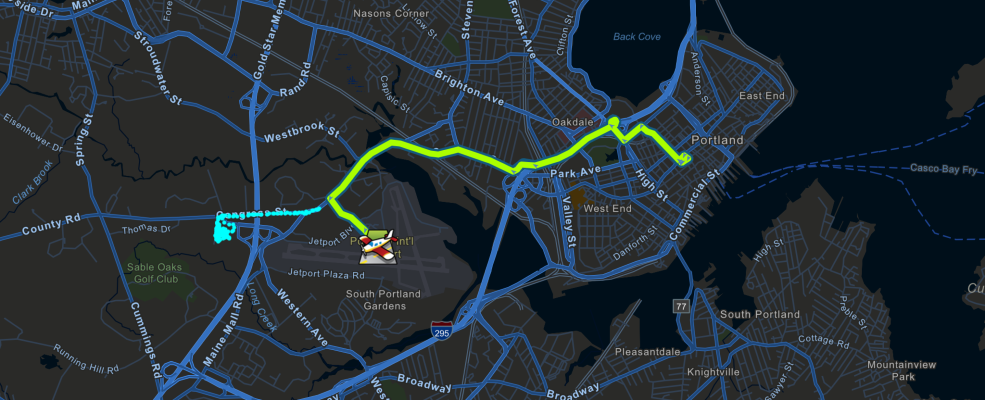

In [48]:
line_layer = route_layers[0]
line_geom = Polyline(line_layer.query().features[0].geometry)
buffered_line_geom = arcgis.geometry.buffer(geometries=[line_geom], in_sr=102100, distances=buffer_distance, out_sr=4326, unit=9001, geodesic=True)
new_features = []
for feature in route_tracks.features:
    point = arcgis.geometry.Point(json.dumps(feature.geometry))
    point_on_route = point.within(buffered_line_geom[0])
    if not point_on_route:
        new_features.append(feature)

if len(new_features) == 0:
    sys.exit("User did not deviate from route!")
route_tracks._features = new_features
map4 = gis.map(zoomlevel=12)
map4.center = default_map_center
map4.basemap = default_basemap
for layer in route_layers:
    map4.add_layer(layer)
map4.add_layer(route_tracks, {"symbol":{"color":[0,255,255,255],"size":3,"type":"esriSMS","style":"esriSMSCircle"}})
map4

In [49]:
start_deviation = pendulum.from_timestamp(int(route_tracks.features[0].attributes["location_timestamp"])/1000)
end_deviation = pendulum.from_timestamp(int(route_tracks.features[-1].attributes["location_timestamp"])/1000)
start_dev_timestamp = start_deviation.strftime("%Y-%m-%d %H:%M:%S")
end_dev_timestamp = end_deviation.strftime("%Y-%m-%d %H:%M:%S")
print("Start of Deviation: " + start_dev_timestamp + ", End of Deviation: " + end_dev_timestamp)

Start of Deviation: 2020-02-13 09:27:40, End of Deviation: 2020-02-13 09:45:05
